# Sentiment Classification Implementation

Best Variant: clean
Best Model: SVM
Cross-validation results:
        Variant                Model  Accuracy  Accuracy Rank
0        clean                  SVM  0.896750              1
1        clean  Logistic Regression  0.895000              2
2   lemmatized                  SVM  0.884875              3
3   lemmatized  Logistic Regression  0.882750              4
4      stemmed                  SVM  0.876000              5
5      stemmed  Logistic Regression  0.875875              6
6   lemmatized        Random Forest  0.860000              7
7        clean        Random Forest  0.855125              8
8      stemmed        Random Forest  0.853625              9
9   lemmatized        Decision Tree  0.822625             10
10       clean          Naive Bayes  0.817625             11
11     stemmed        Decision Tree  0.813875             12
12  lemmatized          Naive Bayes  0.813000             13
13       clean        Decision Tree  0.808875             14
14     stemmed        

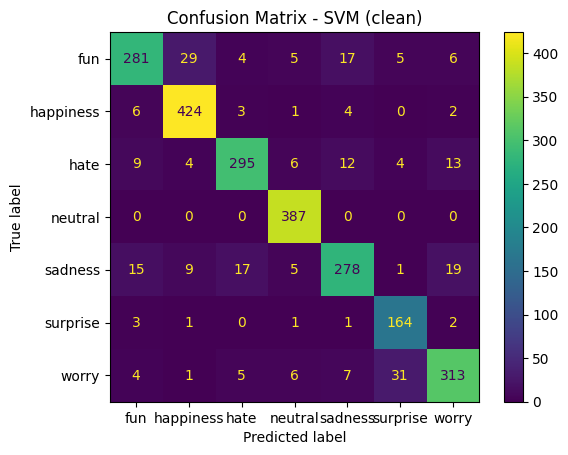

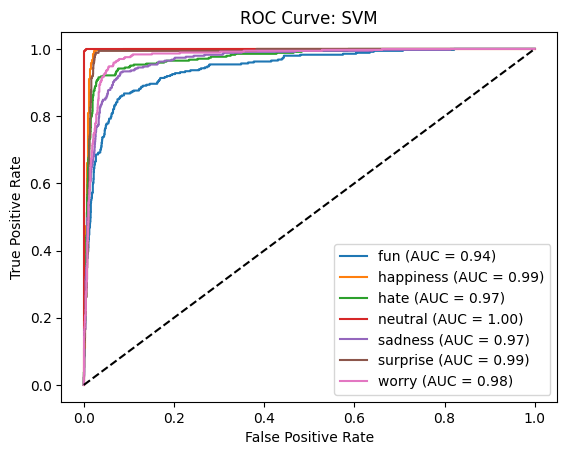

✅ Predictions saved to 'predictions.txt'


In [1]:
from src_modules.libraries import *
from src_modules.methods import preprocess_text, TextModelEvaluator, TextPreprocessor

def train_test(train_path, test_path):

    # === Load Data ===
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # === Preprocess Text ===
    TP = TextPreprocessor()
    for col in ['text']:
        train_df['text_clean'] = train_df[col].apply(lambda x: TP.preprocess_text(x))
        train_df['text_lemmatized'] = train_df[col].apply(lambda x: TP.preprocess_text(x, lemmatize=True))
        train_df['text_stemmed'] = train_df[col].apply(lambda x: TP.preprocess_text(x, stem=True))

        test_df['text_clean'] = test_df[col].apply(lambda x: TP.preprocess_text(x))
        test_df['text_lemmatized'] = test_df[col].apply(lambda x: TP.preprocess_text(x, lemmatize=True))
        test_df['text_stemmed'] = test_df[col].apply(lambda x: TP.preprocess_text(x, stem=True))

    # === Define Variants ===
    text_variants = {
        "clean": "text_clean",
        "lemmatized": "text_lemmatized",
        "stemmed": "text_stemmed"
    }

    # === Initialize Evaluator ===
    evaluator = TextModelEvaluator(text_columns=text_variants)

    # === Step 1: Model Comparison ===
    results_df = evaluator.compare_models(train_df, cross_validate=True)
    print("Best Variant:", evaluator.best_variant)
    print("Best Model:", evaluator.best_model_name)
    print("Cross-validation results:\n", results_df)

    # === Step 2: Hyperparameter Tuning ===
    if evaluator.best_model_name == 'SVM':
        grid_params = {'C': [0.1, 1, 10]}
    elif evaluator.best_model_name == 'Logistic Regression':
        grid_params = {'C': [0.1, 1, 10]}
    elif evaluator.best_model_name == 'Random Forest':
        grid_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    else:
        grid_params = {}

    if grid_params:
        best_params, best_score = evaluator.tune_best_model(train_df, grid_params)
        print("Best hyperparameters:", best_params)
        print(f"Best cross-validated score after tuning: {best_score:.6f}")

    # === Step 3: Evaluation on Validation Set ===
    train_eval, val_eval = train_test_split(train_df, test_size=0.3, stratify=train_df["emotion"])
    metrics = evaluator.evaluate_on_validation(train_eval, val_eval, plot_confusion=True, plot_roc=True)
    #print("Validation Set Evaluation Metrics:\n", metrics)

    # === Step 4: Final Training and Prediction ===
    evaluator.train_final_model(train_df)
    predictions = evaluator.predict(test_df)

    # === Step 5: Save Predictions ===
    with open("predictions.txt", "w", encoding="utf-8") as f:
        for label in predictions:
            f.write(str(label) + "\n")

    print("✅ Predictions saved to 'predictions.txt'")


train_test("train.csv", "test.csv")
